## Imports

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import random
import cv2
import zipfile
import sys
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [2]:
# drive.mount('/content/drive')
# dataset_path = '/content/drive/MyDrive/Deep-HW2-Data.zip'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
!gdown 'https://drive.google.com/uc?id=1gDO7-4SgEfXB_Ls5_LS0ycyMNMPyy1sG'
with zipfile.ZipFile('/content/Deep-HW2-Data.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/')

Downloading...
From (original): https://drive.google.com/uc?id=1gDO7-4SgEfXB_Ls5_LS0ycyMNMPyy1sG
From (redirected): https://drive.google.com/uc?id=1gDO7-4SgEfXB_Ls5_LS0ycyMNMPyy1sG&confirm=t&uuid=f3bbdc58-711a-44bc-83b7-aec01a01694c
To: /content/Deep-HW2-Data.zip
100% 53.2M/53.2M [00:00<00:00, 64.8MB/s]


## Utilities

In [5]:
def plot_metric(metric, train_metric, val_metric, epochs=50):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_metric, label=f'Training {metric}', alpha=0.5)
    plt.plot(range(1, epochs + 1), val_metric, label=f'Validation {metric}', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'Training and Validation {metric} Over Epochs')
    plt.legend()
    plt.show()

def load_from_dataset(path, img_size_w, img_size_h):
    data = []
    for f in glob.iglob(path):
        img = cv2.imread(f)
        img = cv2.resize(img,(img_size_w,img_size_h))
        data.append(img)
    return data


## Hyper Parameters

In [6]:
in_channels = 3
num_classes = 2
learning_rate = 3e-4 # karpathy's constant
batch_size = 256
num_epochs = 75

## Dataset

#### Dataset Class

In [7]:
class Data(Dataset):
    def __init__(self, device, img_size_w = 224, img_size_h = 224):
        self.img_size_w = img_size_w
        self.img_size_h = img_size_h
        self.device = device
        self.mode = 'train'

        self.load_data()
        self.split_data()

    def set_mode(self, mode):
        self.mode = mode

    def set_transformers(self, train_transform=None, val_transform=None):
        # Define transforms
        self.train_transform = train_transform if train_transform else transforms.Compose([
            transforms.ToPILImage(),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomRotation(10),
            transforms.ToTensor(),
            #transforms.Resize((img_size_h, img_size_w)),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.val_transform = val_transform if val_transform else transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            #transforms.Resize((img_size_h, img_size_w)),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(
            self.images, self.labels, test_size=0.2, random_state=42
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.5, random_state=42
        )

        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
        self.X_test, self.y_test = X_test, y_test

    def load_data(self):
        benign_path = "/content/data/benign/*.jpg"
        malignant_path = "/content/data/malignant/*.jpg"

        benign = load_from_dataset(benign_path, self.img_size_w, self.img_size_h)
        malignant = load_from_dataset(malignant_path, self.img_size_w, self.img_size_h)

        benign = np.array(benign, dtype=np.float32)
        malignant = np.array(malignant, dtype=np.float32)

        benign_labels = np.zeros(benign.shape[0], dtype=np.float32)
        malignant_labels = np.full(malignant.shape[0], 1.0)

        print (f'dataset shape is : {benign.shape}')

        self.images = np.concatenate((benign, malignant), axis=0)
        self.labels = np.concatenate((benign_labels, malignant_labels))

    def train_test_test(self):
        self.X_train, self.X_test, self.y_train, self.y_test = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
        elif self.mode == 'test':
            return self.X_test.shape[0]

    def __getitem__(self, idx):
        if self.mode == 'train':
            image, label = self.X_train[idx], self.y_train[idx]
            image = self.train_transform(image)
        elif self.mode == 'val':
            image, label = self.X_val[idx], self.y_val[idx]
            image = self.val_transform(image)
        elif self.mode == 'test':
            image, label = self.X_test[idx], self.y_test[idx]
            image = self.val_transform(image)

        label = torch.tensor(label, dtype=torch.float32).to(device)
        return {'image': image, 'label': label}

    def normalize(self):
        self.images = self.images/255.0

    def analyze_class_distribution(self):
        benign_count = np.sum(self.labels == 0)
        malignant_count = np.sum(self.labels == 1)

        print(f"Class Distribution:")
        print(f"  Benign:    {benign_count}")
        print(f"  Malignant: {malignant_count}")

        plt.figure(figsize=(6, 4))  # Adjust the width and height as needed
        plt.bar(['Benign', 'Malignant'], [benign_count, malignant_count], color=['blue', 'red'])
        plt.title('Class Distribution')
        plt.ylabel('Count')
        plt.show()

    def balance_with_oversampling(self):
        ros = RandomOverSampler(random_state=42)
        self.images, self.labels = ros.fit_resample(self.images.reshape(len(self.images), -1), self.labels)
        self.images = self.images.reshape(-1, self.img_size_h, self.img_size_w, 3)  # Adjust to original dimensions

    def augment_minority_class(self):
        malignant_indices = np.where(self.labels == 1)[0]
        additional_samples = []
        additional_labels = []
        for idx in malignant_indices:
            image = self.images[idx]
            augmented_image = self.train_transform(image)  # Apply transformations
            additional_samples.append(augmented_image.numpy())
            additional_labels.append(1)

        self.images = np.concatenate((self.images, np.array(additional_samples)))
        self.labels = np.concatenate((self.labels, np.array(additional_labels)))

    def balance_with_undersampling(self):
        rus = RandomUnderSampler(random_state=42)
        self.images, self.labels = rus.fit_resample(self.images.reshape(len(self.images), -1), self.labels)
        self.images = self.images.reshape(-1, self.img_size_h, self.img_size_w, 3)  # Adjust to original dimensions

    def balance_with_smote(self):
        smote = SMOTETomek(random_state=42)
        self.images, self.labels = smote.fit_resample(self.images.reshape(len(self.images), -1), self.labels)
        self.images = self.images.reshape(-1, self.img_size_h, self.img_size_w, 3)  # Adjust to original dimensions

In [8]:
# custom_train_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     ToTensorAndMove(device),
# ])

# custom_val_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     ToTensorAndMove(device),
# ])

#### Create Normal Dataset

In [9]:
def count_batches(loader):
    return sum(1 for _ in loader)

In [10]:
dataset = Data(device=device, img_size_w=28, img_size_h=28)
dataset.set_transformers() # custom_train_transform, custom_val_transform

dataset.balance_with_undersampling()
dataset.normalize()

# Set the dataset mode for each DataLoader
# TODO:: Not Sure
dataset.set_mode('train')
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
train_size = count_batches(train_loader)

dataset.set_mode('val')
val_loader = DataLoader(dataset, batch_size=32, shuffle=False)
val_size = count_batches(val_loader)

dataset.set_mode('test')
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)
test_size = count_batches(test_loader)

print(f"Train Loader Size: {train_size} batches")
print(f"Val Loader Size: {val_size} batches")
print(f"Test Loader Size: {test_size} batches")

dataset shape is : (1800, 28, 28, 3)
Train Loader Size: 42 batches
Val Loader Size: 42 batches
Test Loader Size: 21 batches


#### Create GoogleNet Dataset

In [11]:
google_net_dataset = Data(device=device)
google_net_dataset.set_transformers() # custom_train_transform, custom_val_transform

google_net_dataset.balance_with_undersampling()
google_net_dataset.normalize()

# Set the google_net_dataset mode for each DataLoader
# TODO:: Not Sure
google_net_dataset.set_mode('train')
gn_train_loader = DataLoader(google_net_dataset, batch_size=32, shuffle=True)

google_net_dataset.set_mode('val')
gn_val_loader = DataLoader(google_net_dataset, batch_size=32, shuffle=False)

google_net_dataset.set_mode('test')
gn_test_loader = DataLoader(google_net_dataset, batch_size=32, shuffle=False)

dataset shape is : (1800, 224, 224, 3)


## Model1

#### Class

In [12]:
class ToTensorAndMove:
    def __init__(self, device):
        self.to_tensor = transforms.ToTensor()
        self.device = device
    def __call__(self, img):
        tensor = self.to_tensor(img)
        return tensor.to(self.device)

In [13]:
class SkinCancerCNN(nn.Module):
    def __init__(self):
        super(SkinCancerCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(2 * 2 * 128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = F.relu(self.conv4(x))
        x = self.pool4(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def eval_model(model, criterion, dataset, loader, mode):
    model.eval()
    dataset.set_mode(mode)
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        with tqdm(total=len(loader), desc="Validation", unit="batch") as pbar:
            for batch in loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
                pbar.update(1)

    val_loss = val_loss / len(loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [15]:
def train_model(model, optimizer, criterion, dataset, train_loader, val_loader, num_epochs=10):
    model.to(device)
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        dataset.set_mode('train')
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for batch in train_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
                pbar.update(1)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        # print(f"Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)

        val_loss, val_acc = eval_model(model, criterion, dataset, val_loader, 'val')
        # print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        print("-" * 30, "\n")
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        mean_loss = sum(train_losses) / len(train_losses)
        mean_loss = round(mean_loss, 2)
        scheduler.step(mean_loss)

    return train_accuracies, train_losses, val_accuracies, val_losses


#### Train

In [16]:
model = SkinCancerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
custom_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

custom_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

In [21]:
dataset = Data(device=device, img_size_w=28, img_size_h=28)
dataset.set_transformers(custom_train_transform, custom_val_transform) # custom_train_transform, custom_val_transform

dataset.balance_with_undersampling()
dataset.normalize()

dataset.set_mode('train')
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
print(type(train_loader))

dataset.set_mode('val')
val_loader = DataLoader(dataset, batch_size=32, shuffle=False)
print(type(val_loader))

dataset.set_mode('test')
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)
print(type(test_loader))

dataset shape is : (1800, 28, 28, 3)
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [22]:
train_acc, train_loss, val_acc, val_loss = train_model(model, optimizer, criterion, dataset, train_loader, val_loader, num_epochs=num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.95batch/s, accuracy=54.4, loss=0.674]


------------------------------ 

Epoch [2/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 34.91batch/s, accuracy=74.8, loss=0.641]


------------------------------ 

Epoch [3/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.46batch/s, accuracy=78.4, loss=0.598]


------------------------------ 

Epoch [4/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 30.47batch/s, accuracy=77.8, loss=0.704]


------------------------------ 

Epoch [5/75]


Validation: 100%|██████████| 42/42 [00:02<00:00, 19.90batch/s, accuracy=78.4, loss=0.632]


------------------------------ 

Epoch [6/75]


Validation: 100%|██████████| 42/42 [00:02<00:00, 18.99batch/s, accuracy=79.8, loss=0.737]


------------------------------ 

Epoch [7/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 25.28batch/s, accuracy=79.5, loss=0.662]


------------------------------ 

Epoch [8/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 23.58batch/s, accuracy=78.5, loss=0.629]


------------------------------ 

Epoch [9/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.37batch/s, accuracy=80, loss=0.582]


------------------------------ 

Epoch [10/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.23batch/s, accuracy=79.5, loss=0.558]


------------------------------ 

Epoch [11/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 34.26batch/s, accuracy=78.6, loss=0.644]


------------------------------ 

Epoch [12/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 38.75batch/s, accuracy=80.4, loss=0.55]


------------------------------ 

Epoch [13/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 38.05batch/s, accuracy=80.3, loss=0.585]


------------------------------ 

Epoch [14/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.51batch/s, accuracy=80.7, loss=0.577]


------------------------------ 

Epoch [15/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.89batch/s, accuracy=80.1, loss=0.576]


------------------------------ 

Epoch [16/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 27.87batch/s, accuracy=79.1, loss=0.495]


------------------------------ 

Epoch [17/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.79batch/s, accuracy=79.2, loss=0.668]


------------------------------ 

Epoch [18/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.24batch/s, accuracy=82.1, loss=0.634]


------------------------------ 

Epoch [19/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.31batch/s, accuracy=80.7, loss=0.55]


------------------------------ 

Epoch [20/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 31.17batch/s, accuracy=81.1, loss=0.574]


------------------------------ 

Epoch [21/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.41batch/s, accuracy=81.1, loss=0.563]


------------------------------ 

Epoch [22/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.77batch/s, accuracy=82.6, loss=0.49]


------------------------------ 

Epoch [23/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.38batch/s, accuracy=78.2, loss=0.612]


------------------------------ 

Epoch [24/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.20batch/s, accuracy=81.9, loss=0.438]


------------------------------ 

Epoch [25/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 32.72batch/s, accuracy=82.4, loss=0.462]


------------------------------ 

Epoch [26/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.59batch/s, accuracy=81.7, loss=0.5]


------------------------------ 

Epoch [27/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.03batch/s, accuracy=82.9, loss=0.473]


------------------------------ 

Epoch [28/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.83batch/s, accuracy=81.7, loss=0.553]


------------------------------ 

Epoch [29/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 31.60batch/s, accuracy=77.5, loss=0.674]


------------------------------ 

Epoch [30/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 32.68batch/s, accuracy=81.4, loss=0.46]


------------------------------ 

Epoch [31/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.31batch/s, accuracy=83, loss=0.467]


------------------------------ 

Epoch [32/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.84batch/s, accuracy=82, loss=0.539]


------------------------------ 

Epoch [33/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 36.90batch/s, accuracy=82.7, loss=0.501]


------------------------------ 

Epoch [34/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 26.87batch/s, accuracy=81.7, loss=0.5]


------------------------------ 

Epoch [35/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.28batch/s, accuracy=82, loss=0.564]


------------------------------ 

Epoch [36/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.79batch/s, accuracy=81.4, loss=0.413]


------------------------------ 

Epoch [37/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.35batch/s, accuracy=82.7, loss=0.459]


------------------------------ 

Epoch [38/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 28.08batch/s, accuracy=82.6, loss=0.514]


------------------------------ 

Epoch [39/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.46batch/s, accuracy=81.3, loss=0.514]


------------------------------ 

Epoch [40/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.10batch/s, accuracy=81.4, loss=0.521]


------------------------------ 

Epoch [41/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.08batch/s, accuracy=83, loss=0.522]


------------------------------ 

Epoch [42/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 33.40batch/s, accuracy=81.4, loss=0.546]


------------------------------ 

Epoch [43/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.01batch/s, accuracy=83.1, loss=0.446]


------------------------------ 

Epoch [44/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.99batch/s, accuracy=81.7, loss=0.51]


------------------------------ 

Epoch [45/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.26batch/s, accuracy=81.9, loss=0.528]


------------------------------ 

Epoch [46/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.61batch/s, accuracy=82.8, loss=0.476]


------------------------------ 

Epoch [47/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 29.61batch/s, accuracy=82.4, loss=0.524]


------------------------------ 

Epoch [48/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.49batch/s, accuracy=81.7, loss=0.576]


------------------------------ 

Epoch [49/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.01batch/s, accuracy=82, loss=0.54]


------------------------------ 

Epoch [50/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.63batch/s, accuracy=82.7, loss=0.595]


------------------------------ 

Epoch [51/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 31.96batch/s, accuracy=82.1, loss=0.483]


------------------------------ 

Epoch [52/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.09batch/s, accuracy=82, loss=0.533]


------------------------------ 

Epoch [53/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.38batch/s, accuracy=82.5, loss=0.559]


------------------------------ 

Epoch [54/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.14batch/s, accuracy=83.2, loss=0.549]


------------------------------ 

Epoch [55/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.71batch/s, accuracy=83.1, loss=0.541]


------------------------------ 

Epoch [56/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 29.55batch/s, accuracy=82.3, loss=0.5]


------------------------------ 

Epoch [57/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.82batch/s, accuracy=81.1, loss=0.49]


------------------------------ 

Epoch [58/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 38.94batch/s, accuracy=82.5, loss=0.6]


------------------------------ 

Epoch [59/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.60batch/s, accuracy=80.7, loss=0.521]


------------------------------ 

Epoch [60/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 31.74batch/s, accuracy=82.7, loss=0.47]


------------------------------ 

Epoch [61/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.05batch/s, accuracy=83.2, loss=0.496]


------------------------------ 

Epoch [62/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.60batch/s, accuracy=84, loss=0.511]


------------------------------ 

Epoch [63/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.88batch/s, accuracy=82.6, loss=0.501]


------------------------------ 

Epoch [64/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.90batch/s, accuracy=83, loss=0.692]


------------------------------ 

Epoch [65/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 30.53batch/s, accuracy=82.6, loss=0.531]


------------------------------ 

Epoch [66/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.90batch/s, accuracy=83.5, loss=0.542]


------------------------------ 

Epoch [67/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.06batch/s, accuracy=81.8, loss=0.605]


------------------------------ 

Epoch [68/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.51batch/s, accuracy=82.6, loss=0.456]


------------------------------ 

Epoch [69/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 32.16batch/s, accuracy=83.5, loss=0.572]


------------------------------ 

Epoch [70/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.87batch/s, accuracy=82.3, loss=0.604]


------------------------------ 

Epoch [71/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.54batch/s, accuracy=82.5, loss=0.487]


------------------------------ 

Epoch [72/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.67batch/s, accuracy=82.2, loss=0.457]


------------------------------ 

Epoch [73/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.70batch/s, accuracy=82.3, loss=0.428]


------------------------------ 

Epoch [74/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 32.98batch/s, accuracy=82.9, loss=0.6]


------------------------------ 

Epoch [75/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.39batch/s, accuracy=82.3, loss=0.461]

------------------------------ 



#### Show Result

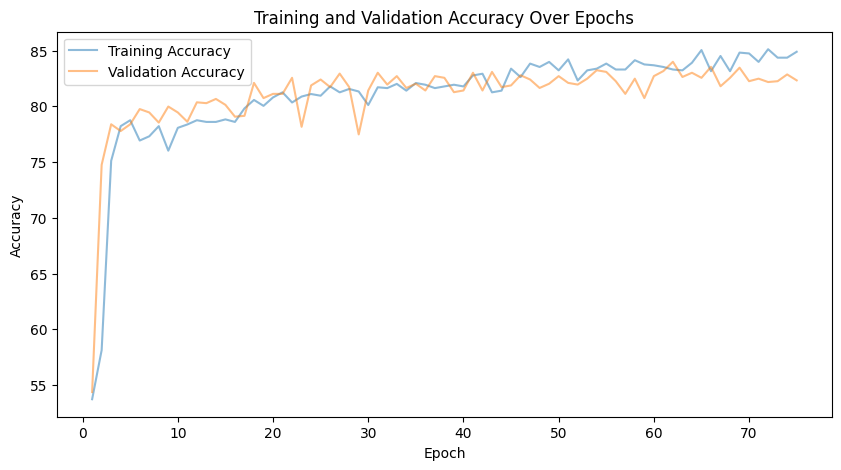

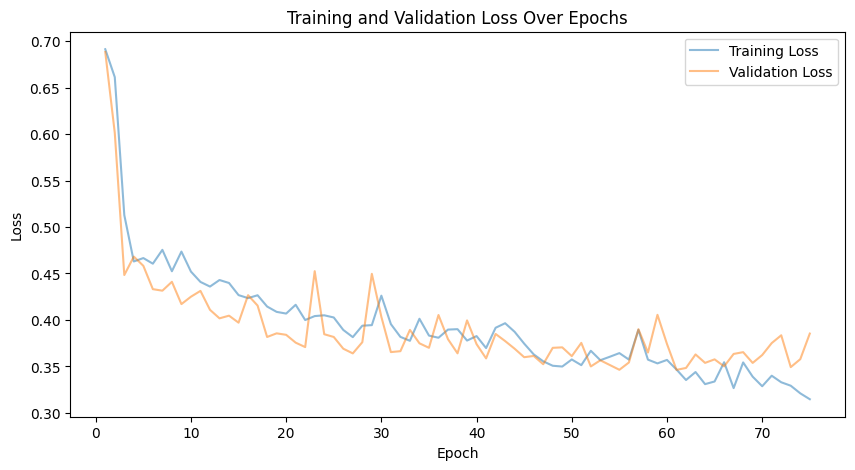

In [23]:
plot_metric('Accuracy', train_acc, val_acc, epochs=num_epochs)
plot_metric('Loss', train_loss, val_loss, epochs=num_epochs)

#### Test

In [24]:
test_loss, test_acc = eval_model(model, criterion, dataset, test_loader, 'test')
print(f'test loss = {test_loss}')
print(f'test acc = {test_acc}')

Validation: 100%|██████████| 21/21 [00:00<00:00, 41.32batch/s, accuracy=78.6, loss=0.267]

test loss = 0.4335316377026694
test acc = 78.63636363636364


## Model2

#### Model Class

In [25]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

In [26]:
class ImprovedSkinCancerCNN(nn.Module):
    def __init__(self):
        super(ImprovedSkinCancerCNN, self).__init__()

        self.conv1 = conv_block(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.15)

        self.conv2 = conv_block(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.15)

        self.conv3 = conv_block(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=2)
        self.dropout3 = nn.Dropout(p=0.15)

        self.conv4 = conv_block(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(p=0.15)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(2 * 2 * 512, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Train

In [28]:
custom_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

custom_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

In [29]:
dataset2 = Data(device=device, img_size_w=28, img_size_h=28)
dataset2.set_transformers(custom_train_transform, custom_val_transform) # custom_train_transform, custom_val_transform

dataset2.balance_with_undersampling()
dataset2.normalize()

dataset2.set_mode('train')
train_loader2 = DataLoader(dataset2, batch_size=32, shuffle=True)
print(type(train_loader2))

dataset2.set_mode('val')
val_loader2 = DataLoader(dataset2, batch_size=32, shuffle=False)
print(type(val_loader2))

dataset2.set_mode('test')
test_loader2 = DataLoader(dataset2, batch_size=32, shuffle=False)
print(type(test_loader2))

dataset shape is : (1800, 28, 28, 3)
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [30]:
improvedModel = ImprovedSkinCancerCNN().to(device)
optimizer = optim.Adam(improvedModel.parameters(), lr=learning_rate)
train_acc, train_loss, val_acc, val_loss = train_model(improvedModel, optimizer, criterion, dataset2, train_loader2, val_loader2, num_epochs=num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 36.02batch/s, accuracy=65, loss=0.481]


------------------------------ 

Epoch [2/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 37.25batch/s, accuracy=78.9, loss=0.461]


------------------------------ 

Epoch [3/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.41batch/s, accuracy=81.3, loss=0.464]


------------------------------ 

Epoch [4/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.51batch/s, accuracy=80.2, loss=0.512]


------------------------------ 

Epoch [5/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 22.63batch/s, accuracy=83.2, loss=0.318]


------------------------------ 

Epoch [6/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 23.18batch/s, accuracy=83.6, loss=0.383]


------------------------------ 

Epoch [7/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 32.66batch/s, accuracy=81.5, loss=0.394]


------------------------------ 

Epoch [8/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 36.66batch/s, accuracy=82.9, loss=0.367]


------------------------------ 

Epoch [9/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 24.51batch/s, accuracy=83.6, loss=0.367]


------------------------------ 

Epoch [10/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 25.42batch/s, accuracy=82.3, loss=0.398]


------------------------------ 

Epoch [11/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 37.75batch/s, accuracy=82.7, loss=0.388]


------------------------------ 

Epoch [12/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 22.89batch/s, accuracy=84.1, loss=0.367]


------------------------------ 

Epoch [13/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.90batch/s, accuracy=83.2, loss=0.255]


------------------------------ 

Epoch [14/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.88batch/s, accuracy=80.5, loss=0.494]


------------------------------ 

Epoch [15/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.01batch/s, accuracy=83.5, loss=0.335]


------------------------------ 

Epoch [16/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 31.55batch/s, accuracy=83.2, loss=0.304]


------------------------------ 

Epoch [17/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.92batch/s, accuracy=82.9, loss=0.45]


------------------------------ 

Epoch [18/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.51batch/s, accuracy=76.6, loss=0.427]


------------------------------ 

Epoch [19/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.84batch/s, accuracy=83.6, loss=0.371]


------------------------------ 

Epoch [20/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.99batch/s, accuracy=83.6, loss=0.353]


------------------------------ 

Epoch [21/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 31.53batch/s, accuracy=85, loss=0.317]


------------------------------ 

Epoch [22/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.95batch/s, accuracy=81.4, loss=0.492]


------------------------------ 

Epoch [23/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.57batch/s, accuracy=86.3, loss=0.252]


------------------------------ 

Epoch [24/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.87batch/s, accuracy=85, loss=0.352]


------------------------------ 

Epoch [25/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 32.13batch/s, accuracy=83.2, loss=0.513]


------------------------------ 

Epoch [26/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.82batch/s, accuracy=83.9, loss=0.593]


------------------------------ 

Epoch [27/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.22batch/s, accuracy=85.1, loss=0.222]


------------------------------ 

Epoch [28/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.76batch/s, accuracy=84.9, loss=0.228]


------------------------------ 

Epoch [29/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 34.51batch/s, accuracy=86.2, loss=0.438]


------------------------------ 

Epoch [30/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.01batch/s, accuracy=87.1, loss=0.267]


------------------------------ 

Epoch [31/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.36batch/s, accuracy=86, loss=0.588]


------------------------------ 

Epoch [32/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.12batch/s, accuracy=86.6, loss=0.244]


------------------------------ 

Epoch [33/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.70batch/s, accuracy=85.1, loss=0.229]


------------------------------ 

Epoch [34/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 32.01batch/s, accuracy=84.5, loss=0.538]


------------------------------ 

Epoch [35/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.54batch/s, accuracy=86.1, loss=0.384]


------------------------------ 

Epoch [36/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.14batch/s, accuracy=85.3, loss=0.225]


------------------------------ 

Epoch [37/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.69batch/s, accuracy=85.6, loss=0.177]


------------------------------ 

Epoch [38/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 30.96batch/s, accuracy=84.4, loss=0.507]


------------------------------ 

Epoch [39/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.18batch/s, accuracy=86, loss=0.403]


------------------------------ 

Epoch [40/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.12batch/s, accuracy=86.8, loss=0.425]


------------------------------ 

Epoch [41/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.95batch/s, accuracy=80.9, loss=0.891]


------------------------------ 

Epoch [42/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 31.43batch/s, accuracy=86.7, loss=0.227]


------------------------------ 

Epoch [43/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.41batch/s, accuracy=84.4, loss=0.459]


------------------------------ 

Epoch [44/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.76batch/s, accuracy=86.3, loss=0.503]


------------------------------ 

Epoch [45/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.03batch/s, accuracy=86.8, loss=0.383]


------------------------------ 

Epoch [46/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 36.44batch/s, accuracy=87.7, loss=0.368]


------------------------------ 

Epoch [47/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.60batch/s, accuracy=86.3, loss=0.269]


------------------------------ 

Epoch [48/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.27batch/s, accuracy=84.9, loss=0.561]


------------------------------ 

Epoch [49/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.09batch/s, accuracy=85.1, loss=0.325]


------------------------------ 

Epoch [50/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.64batch/s, accuracy=87.5, loss=0.492]


------------------------------ 

Epoch [51/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 35.00batch/s, accuracy=86.8, loss=0.25]


------------------------------ 

Epoch [52/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.65batch/s, accuracy=85.7, loss=0.176]


------------------------------ 

Epoch [53/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.20batch/s, accuracy=85.7, loss=0.29]


------------------------------ 

Epoch [54/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.03batch/s, accuracy=84.7, loss=0.396]


------------------------------ 

Epoch [55/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 28.58batch/s, accuracy=84.2, loss=0.55]


------------------------------ 

Epoch [56/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.50batch/s, accuracy=86.4, loss=0.202]


------------------------------ 

Epoch [57/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.19batch/s, accuracy=85.4, loss=0.239]


------------------------------ 

Epoch [58/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 41.08batch/s, accuracy=87.7, loss=0.681]


------------------------------ 

Epoch [59/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 28.67batch/s, accuracy=85.5, loss=0.151]


------------------------------ 

Epoch [60/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.49batch/s, accuracy=83.7, loss=0.247]


------------------------------ 

Epoch [61/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.88batch/s, accuracy=86.2, loss=0.308]


------------------------------ 

Epoch [62/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.39batch/s, accuracy=85.4, loss=0.266]


------------------------------ 

Epoch [63/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.07batch/s, accuracy=85.7, loss=0.254]


------------------------------ 

Epoch [64/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 35.10batch/s, accuracy=86.5, loss=0.403]


------------------------------ 

Epoch [65/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.90batch/s, accuracy=85.4, loss=0.52]


------------------------------ 

Epoch [66/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.41batch/s, accuracy=85.4, loss=0.62]


------------------------------ 

Epoch [67/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.73batch/s, accuracy=86.3, loss=0.179]


------------------------------ 

Epoch [68/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 30.26batch/s, accuracy=85.9, loss=0.202]


------------------------------ 

Epoch [69/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.75batch/s, accuracy=85.4, loss=0.368]


------------------------------ 

Epoch [70/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.96batch/s, accuracy=85.5, loss=0.252]


------------------------------ 

Epoch [71/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 38.79batch/s, accuracy=84.2, loss=0.806]


------------------------------ 

Epoch [72/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 30.86batch/s, accuracy=83.2, loss=0.769]


------------------------------ 

Epoch [73/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 39.95batch/s, accuracy=86.7, loss=0.328]


------------------------------ 

Epoch [74/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.28batch/s, accuracy=84.2, loss=0.449]


------------------------------ 

Epoch [75/75]


Validation: 100%|██████████| 42/42 [00:01<00:00, 40.57batch/s, accuracy=86, loss=0.378]

------------------------------ 



#### Show Results

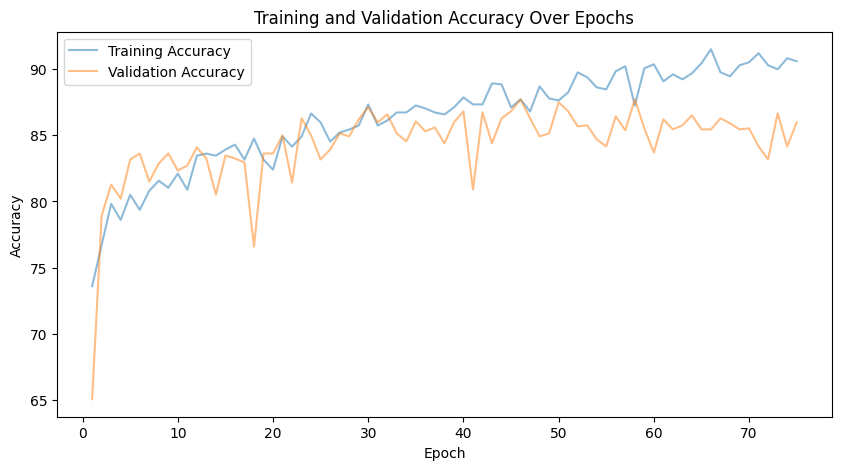

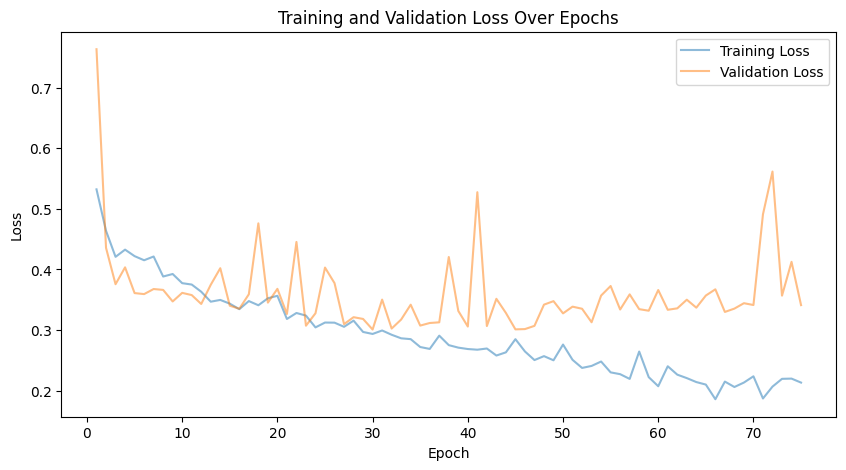

In [31]:
plot_metric('Accuracy', train_acc, val_acc, epochs=num_epochs)
plot_metric('Loss', train_loss, val_loss, epochs=num_epochs)

#### Test

In [33]:
test_loss, test_acc = eval_model(improvedModel, criterion, dataset2, test_loader2, 'test')
print(f'test loss = {test_loss}')
print(f'test acc = {test_acc}')

Validation: 100%|██████████| 21/21 [00:00<00:00, 22.74batch/s, accuracy=83.3, loss=0.365]

test loss = 0.364307117604074
test acc = 83.33333333333333


## GoogleNet

#### GoogleNet Model

In [34]:
class GoogLeNet(nn.Module):
  def __init__(self, aux_logits=True, num_classes=4):
    super(GoogLeNet, self).__init__()
    assert aux_logits == True or aux_logits == False
    self.aux_logits = aux_logits

    self.conv1 = conv_block(
        in_channels=3,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
    )

    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)

    if self.aux_logits:
      self.aux1 = InceptionAux(512, num_classes)
      self.aux2 = InceptionAux(528, num_classes)
    else:
      self.aux1 = self.aux2 = None

  def forward(self, x ):
    x = self.conv1(x)       #
    x = self.maxpool1(x)    #
    x = self.conv2(x)       #
    x = self.maxpool2(x)    #

    x = self.inception3a(x) # 192, 64
    x = self.inception3b(x) # 256, 128
    x = self.maxpool3(x)    #

    x = self.inception4a(x) #

    # Auxiliary Softmax classifier 1
    if self.aux_logits and self.training:
      aux1 = self.aux1(x)

    x = self.inception4b(x) # 512, 160
    x = self.inception4c(x) # 512, 128
    x = self.inception4d(x) # 512, 112

    # Auxiliary Softmax classifier 2
    if self.aux_logits and self.training:
      aux2 = self.aux2(x)

    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)
    x = self.fc1(x)

    if self.aux_logits and self.training:
      return aux1, aux2, x
    else:
      return x


class Inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
    super(Inception_block, self).__init__()
    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

    self.branch2 = nn.Sequential(
      conv_block(in_channels, red_3x3, kernel_size=1),
      conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=1),
    )

    self.branch3 = nn.Sequential(
      conv_block(in_channels, red_5x5, kernel_size=1),
      conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
    )

    self.branch4 = nn.Sequential(
      nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
      conv_block(in_channels, out_1x1pool, kernel_size=1),
    )

  def forward(self, x):
    return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


class InceptionAux(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(InceptionAux, self).__init__()
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.7)
    self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
    self.conv = conv_block(in_channels, 128, kernel_size=1)
    self.fc1 = nn.Linear(2048, 1024)
    self.fc2 = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = self.pool(x)
    x = self.conv(x)
    x = x.reshape(x.shape[0], -1)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x


class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))



In [35]:
def train_model(model, optimizer, criterion, dataset, train_loader, val_loader, num_epochs=10):
    model.to(device)
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    # Learning rate scheduler based on validation loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")

        # Training phase
        dataset.mode = 'train'
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for batch in train_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)
                # print('images.shape: ', images.shape)
                # Forward pass
                optimizer.zero_grad()
                outputs = model(images)

                # Compute loss
                if isinstance(outputs, tuple):  # GoogLeNet produces multiple outputs
                    loss1 = criterion(outputs[0], labels.long())
                    loss2 = criterion(outputs[1], labels.long())
                    loss3 = criterion(outputs[2], labels.long())
                    loss = loss1 + loss2 + loss3
                else:
                    loss = criterion(outputs, labels.long())

                # Backward pass
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs[2], 1)
                # _, predicted = outputs[0].max(1)  # Use primary output for accuracy
                total_train += labels.size(0)
                correct_train += predicted.eq(labels).sum().item()

                # Progress bar update
                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct_train / total_train)
                pbar.update(1)

        # Calculate average training loss and accuracy for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        dataset.mode = 'val'
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
                for batch in val_loader:
                    images, labels = batch['image'].to(device), batch['label'].to(device)
                    # print(images.shape)

                    # Forward pass
                    outputs = model(images)

                    # # Compute loss
                    # if isinstance(outputs, tuple):
                    #     loss1 = criterion(outputs[0], labels.long())
                    #     loss2 = criterion(outputs[1], labels.long())
                    #     loss3 = criterion(outputs[2], labels.long())
                    #     loss = loss1 + loss2 + loss3
                    # else:
                    loss = criterion(outputs, labels.long())

                    total_val_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = outputs.max(1)
                    # _, predicted = torch.max(outputs[2], 1)  # Use primary output for accuracy
                    total_val += labels.size(0)
                    correct_val += predicted.eq(labels).sum().item()

                    # Progress bar update
                    pbar.set_postfix(loss=loss.item(), accuracy=100. * correct_val / total_val)
                    pbar.update(1)

        # Calculate average validation loss and accuracy for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100. * correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_losses.append(avg_val_loss)

        # Print epoch results
        print(f"Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        print("-" * 30)

        # Step the learning rate scheduler based on validation loss
        scheduler.step(avg_val_loss)

    return train_accuracies, train_losses, val_accuracies, val_losses


#### Train

In [36]:
custom_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(15),
    #transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

custom_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

In [37]:
# custom_train_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     ToTensorAndMove(device),
# ])

# custom_val_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     ToTensorAndMove(device),
# ])

In [38]:
gn_dataset = Data(device=device)
gn_dataset.set_transformers(custom_train_transform, custom_val_transform) # custom_train_transform, custom_val_transform

gn_dataset.balance_with_undersampling()
gn_dataset.normalize()

gn_dataset.set_mode('train')
gn_train_loader = DataLoader(gn_dataset, batch_size=32, shuffle=True)

gn_dataset.set_mode('val')
gn_val_loader = DataLoader(gn_dataset, batch_size=32, shuffle=False)

gn_dataset.set_mode('test')
gn_test_loader = DataLoader(gn_dataset, batch_size=32, shuffle=False)

dataset shape is : (1800, 224, 224, 3)


In [39]:
gn_model = GoogLeNet().to(device)
optimizer = optim.Adam(gn_model.parameters(), lr=learning_rate)
train_acc, train_loss, val_acc, val_loss = train_model(gn_model, optimizer, criterion, gn_dataset, gn_train_loader, gn_val_loader, num_epochs=num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.33batch/s, accuracy=54.6, loss=0.811]


Training Loss: 1.7001, Accuracy: 74.58%
Validation Loss: 1.1009, Accuracy: 54.59%
------------------------------
Epoch [2/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.32batch/s, accuracy=78.5, loss=0.539]


Training Loss: 1.2476, Accuracy: 78.38%
Validation Loss: 0.4504, Accuracy: 78.47%
------------------------------
Epoch [3/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.76batch/s, accuracy=77.8, loss=0.623]


Training Loss: 1.1992, Accuracy: 79.82%
Validation Loss: 0.4664, Accuracy: 77.79%
------------------------------
Epoch [4/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.37batch/s, accuracy=71.6, loss=0.412]


Training Loss: 1.1847, Accuracy: 79.97%
Validation Loss: 0.4680, Accuracy: 71.57%
------------------------------
Epoch [5/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.79batch/s, accuracy=84.7, loss=0.411]


Training Loss: 1.1838, Accuracy: 78.60%
Validation Loss: 0.3222, Accuracy: 84.69%
------------------------------
Epoch [6/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.39batch/s, accuracy=83.9, loss=0.37]


Training Loss: 1.0644, Accuracy: 82.55%
Validation Loss: 0.3383, Accuracy: 83.85%
------------------------------
Epoch [7/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.47batch/s, accuracy=84.3, loss=0.367]


Training Loss: 1.0452, Accuracy: 82.78%
Validation Loss: 0.3606, Accuracy: 84.31%
------------------------------
Epoch [8/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.79batch/s, accuracy=83.7, loss=0.42]


Training Loss: 0.9931, Accuracy: 83.46%
Validation Loss: 0.4099, Accuracy: 83.70%
------------------------------
Epoch [9/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.69batch/s, accuracy=83.8, loss=0.308]


Training Loss: 0.9141, Accuracy: 85.58%
Validation Loss: 0.3313, Accuracy: 83.78%
------------------------------
Epoch [10/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.35batch/s, accuracy=82.4, loss=0.39]


Training Loss: 0.9591, Accuracy: 85.58%
Validation Loss: 0.3609, Accuracy: 82.41%
------------------------------
Epoch [11/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.65batch/s, accuracy=84.8, loss=0.497]


Training Loss: 0.9324, Accuracy: 85.05%
Validation Loss: 0.3324, Accuracy: 84.76%
------------------------------
Epoch [12/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.33batch/s, accuracy=85.4, loss=0.633]


Training Loss: 0.8503, Accuracy: 85.58%
Validation Loss: 0.3660, Accuracy: 85.44%
------------------------------
Epoch [13/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.24batch/s, accuracy=84.2, loss=0.333]


Training Loss: 0.9162, Accuracy: 86.19%
Validation Loss: 0.3397, Accuracy: 84.23%
------------------------------
Epoch [14/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.66batch/s, accuracy=83.1, loss=0.431]


Training Loss: 0.9060, Accuracy: 85.66%
Validation Loss: 0.3562, Accuracy: 83.09%
------------------------------
Epoch [15/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.36batch/s, accuracy=80.8, loss=0.639]


Training Loss: 0.8362, Accuracy: 87.71%
Validation Loss: 0.4388, Accuracy: 80.82%
------------------------------
Epoch [16/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.87batch/s, accuracy=82.3, loss=0.424]


Training Loss: 0.8305, Accuracy: 87.71%
Validation Loss: 0.3506, Accuracy: 82.34%
------------------------------
Epoch [17/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.45batch/s, accuracy=87.2, loss=0.268]


Training Loss: 0.6963, Accuracy: 89.38%
Validation Loss: 0.2975, Accuracy: 87.19%
------------------------------
Epoch [18/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.34batch/s, accuracy=87.5, loss=0.346]


Training Loss: 0.6225, Accuracy: 90.67%
Validation Loss: 0.2912, Accuracy: 87.49%
------------------------------
Epoch [19/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.45batch/s, accuracy=88.2, loss=0.422]


Training Loss: 0.5880, Accuracy: 91.35%
Validation Loss: 0.3008, Accuracy: 88.17%
------------------------------
Epoch [20/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.65batch/s, accuracy=87.3, loss=0.661]


Training Loss: 0.5494, Accuracy: 91.96%
Validation Loss: 0.3122, Accuracy: 87.34%
------------------------------
Epoch [21/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.49batch/s, accuracy=86.7, loss=0.508]


Training Loss: 0.5277, Accuracy: 92.56%
Validation Loss: 0.3167, Accuracy: 86.66%
------------------------------
Epoch [22/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.66batch/s, accuracy=87, loss=0.8]


Training Loss: 0.5597, Accuracy: 92.56%
Validation Loss: 0.3347, Accuracy: 87.04%
------------------------------
Epoch [23/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.98batch/s, accuracy=87.3, loss=0.488]


Training Loss: 0.5057, Accuracy: 91.27%
Validation Loss: 0.3084, Accuracy: 87.26%
------------------------------
Epoch [24/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.25batch/s, accuracy=86.7, loss=0.795]


Training Loss: 0.4964, Accuracy: 92.64%
Validation Loss: 0.3285, Accuracy: 86.73%
------------------------------
Epoch [25/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.54batch/s, accuracy=87.1, loss=0.86]


Training Loss: 0.4196, Accuracy: 94.76%
Validation Loss: 0.3096, Accuracy: 87.11%
------------------------------
Epoch [26/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.37batch/s, accuracy=85.4, loss=1.09]


Training Loss: 0.4064, Accuracy: 94.54%
Validation Loss: 0.3630, Accuracy: 85.44%
------------------------------
Epoch [27/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.04batch/s, accuracy=87.2, loss=0.862]


Training Loss: 0.3771, Accuracy: 96.28%
Validation Loss: 0.3496, Accuracy: 87.19%
------------------------------
Epoch [28/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.61batch/s, accuracy=87.1, loss=0.838]


Training Loss: 0.3606, Accuracy: 95.52%
Validation Loss: 0.3557, Accuracy: 87.11%
------------------------------
Epoch [29/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.52batch/s, accuracy=86.9, loss=1.06]


Training Loss: 0.2990, Accuracy: 96.59%
Validation Loss: 0.3968, Accuracy: 86.88%
------------------------------
Epoch [30/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.78batch/s, accuracy=87.3, loss=0.922]


Training Loss: 0.2972, Accuracy: 95.60%
Validation Loss: 0.3614, Accuracy: 87.26%
------------------------------
Epoch [31/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.60batch/s, accuracy=87, loss=0.861]


Training Loss: 0.3314, Accuracy: 97.34%
Validation Loss: 0.3753, Accuracy: 87.04%
------------------------------
Epoch [32/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.49batch/s, accuracy=86.5, loss=0.861]


Training Loss: 0.2709, Accuracy: 97.42%
Validation Loss: 0.3718, Accuracy: 86.50%
------------------------------
Epoch [33/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.66batch/s, accuracy=87.5, loss=1.11]


Training Loss: 0.2449, Accuracy: 97.34%
Validation Loss: 0.3667, Accuracy: 87.49%
------------------------------
Epoch [34/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.21batch/s, accuracy=87.3, loss=1.03]


Training Loss: 0.2402, Accuracy: 98.41%
Validation Loss: 0.3780, Accuracy: 87.26%
------------------------------
Epoch [35/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.27batch/s, accuracy=87.5, loss=0.88]


Training Loss: 0.2629, Accuracy: 97.72%
Validation Loss: 0.3702, Accuracy: 87.49%
------------------------------
Epoch [36/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.70batch/s, accuracy=87.3, loss=0.955]


Training Loss: 0.2485, Accuracy: 97.34%
Validation Loss: 0.3820, Accuracy: 87.26%
------------------------------
Epoch [37/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.30batch/s, accuracy=87.6, loss=0.988]


Training Loss: 0.2754, Accuracy: 96.89%
Validation Loss: 0.3585, Accuracy: 87.57%
------------------------------
Epoch [38/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.83batch/s, accuracy=87, loss=0.536]


Training Loss: 0.2298, Accuracy: 98.25%
Validation Loss: 0.3747, Accuracy: 87.04%
------------------------------
Epoch [39/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.49batch/s, accuracy=87.7, loss=0.818]


Training Loss: 0.2289, Accuracy: 97.34%
Validation Loss: 0.3703, Accuracy: 87.72%
------------------------------
Epoch [40/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.41batch/s, accuracy=86.7, loss=0.857]


Training Loss: 0.2268, Accuracy: 98.10%
Validation Loss: 0.3899, Accuracy: 86.73%
------------------------------
Epoch [41/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.73batch/s, accuracy=86.4, loss=1.01]


Training Loss: 0.2275, Accuracy: 97.72%
Validation Loss: 0.4024, Accuracy: 86.35%
------------------------------
Epoch [42/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.14batch/s, accuracy=87.4, loss=0.994]


Training Loss: 0.2211, Accuracy: 98.10%
Validation Loss: 0.3890, Accuracy: 87.41%
------------------------------
Epoch [43/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.33batch/s, accuracy=88.4, loss=0.91]


Training Loss: 0.2129, Accuracy: 97.95%
Validation Loss: 0.3675, Accuracy: 88.40%
------------------------------
Epoch [44/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.58batch/s, accuracy=87.5, loss=0.801]


Training Loss: 0.2120, Accuracy: 98.10%
Validation Loss: 0.3721, Accuracy: 87.49%
------------------------------
Epoch [45/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.31batch/s, accuracy=87.3, loss=0.819]


Training Loss: 0.2215, Accuracy: 98.03%
Validation Loss: 0.3992, Accuracy: 87.26%
------------------------------
Epoch [46/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.74batch/s, accuracy=87.4, loss=0.981]


Training Loss: 0.2161, Accuracy: 98.10%
Validation Loss: 0.3884, Accuracy: 87.41%
------------------------------
Epoch [47/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.54batch/s, accuracy=87.1, loss=0.764]


Training Loss: 0.2123, Accuracy: 98.33%
Validation Loss: 0.3821, Accuracy: 87.11%
------------------------------
Epoch [48/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.26batch/s, accuracy=87.4, loss=0.874]


Training Loss: 0.2011, Accuracy: 98.48%
Validation Loss: 0.3777, Accuracy: 87.41%
------------------------------
Epoch [49/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.70batch/s, accuracy=87.4, loss=0.772]


Training Loss: 0.2236, Accuracy: 97.88%
Validation Loss: 0.3626, Accuracy: 87.41%
------------------------------
Epoch [50/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.09batch/s, accuracy=86.6, loss=0.775]


Training Loss: 0.2435, Accuracy: 98.10%
Validation Loss: 0.3876, Accuracy: 86.58%
------------------------------
Epoch [51/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.08batch/s, accuracy=87.7, loss=0.932]


Training Loss: 0.1803, Accuracy: 98.94%
Validation Loss: 0.3779, Accuracy: 87.72%
------------------------------
Epoch [52/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.72batch/s, accuracy=86.5, loss=1.01]


Training Loss: 0.2038, Accuracy: 98.10%
Validation Loss: 0.3915, Accuracy: 86.50%
------------------------------
Epoch [53/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.30batch/s, accuracy=87, loss=0.756]


Training Loss: 0.2204, Accuracy: 98.03%
Validation Loss: 0.3880, Accuracy: 86.96%
------------------------------
Epoch [54/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.59batch/s, accuracy=87.3, loss=1.05]


Training Loss: 0.2225, Accuracy: 98.18%
Validation Loss: 0.4083, Accuracy: 87.34%
------------------------------
Epoch [55/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.93batch/s, accuracy=87.2, loss=0.894]


Training Loss: 0.1987, Accuracy: 98.33%
Validation Loss: 0.3728, Accuracy: 87.19%
------------------------------
Epoch [56/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.12batch/s, accuracy=88.1, loss=0.863]


Training Loss: 0.2013, Accuracy: 98.18%
Validation Loss: 0.3667, Accuracy: 88.10%
------------------------------
Epoch [57/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.70batch/s, accuracy=87.3, loss=1.09]


Training Loss: 0.2221, Accuracy: 97.88%
Validation Loss: 0.3949, Accuracy: 87.26%
------------------------------
Epoch [58/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.35batch/s, accuracy=87.3, loss=1.13]


Training Loss: 0.2117, Accuracy: 98.33%
Validation Loss: 0.3879, Accuracy: 87.34%
------------------------------
Epoch [59/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.62batch/s, accuracy=87.2, loss=0.701]


Training Loss: 0.2312, Accuracy: 98.18%
Validation Loss: 0.3769, Accuracy: 87.19%
------------------------------
Epoch [60/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.55batch/s, accuracy=87.5, loss=0.753]


Training Loss: 0.2048, Accuracy: 98.10%
Validation Loss: 0.3801, Accuracy: 87.49%
------------------------------
Epoch [61/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.21batch/s, accuracy=86.9, loss=0.814]


Training Loss: 0.2569, Accuracy: 98.25%
Validation Loss: 0.3945, Accuracy: 86.88%
------------------------------
Epoch [62/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.62batch/s, accuracy=87.3, loss=1.09]


Training Loss: 0.2217, Accuracy: 98.03%
Validation Loss: 0.4030, Accuracy: 87.34%
------------------------------
Epoch [63/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.31batch/s, accuracy=87.3, loss=0.888]


Training Loss: 0.2218, Accuracy: 98.18%
Validation Loss: 0.3883, Accuracy: 87.26%
------------------------------
Epoch [64/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.91batch/s, accuracy=86.3, loss=0.84]


Training Loss: 0.2321, Accuracy: 98.33%
Validation Loss: 0.3847, Accuracy: 86.28%
------------------------------
Epoch [65/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.58batch/s, accuracy=86.2, loss=0.997]


Training Loss: 0.2233, Accuracy: 97.57%
Validation Loss: 0.3843, Accuracy: 86.20%
------------------------------
Epoch [66/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.36batch/s, accuracy=86.7, loss=1.05]


Training Loss: 0.2648, Accuracy: 97.34%
Validation Loss: 0.4010, Accuracy: 86.73%
------------------------------
Epoch [67/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.68batch/s, accuracy=87.6, loss=1.13]


Training Loss: 0.2407, Accuracy: 97.34%
Validation Loss: 0.3942, Accuracy: 87.64%
------------------------------
Epoch [68/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.09batch/s, accuracy=87.3, loss=0.906]


Training Loss: 0.2130, Accuracy: 98.03%
Validation Loss: 0.3647, Accuracy: 87.34%
------------------------------
Epoch [69/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.30batch/s, accuracy=86.9, loss=0.918]


Training Loss: 0.1929, Accuracy: 98.79%
Validation Loss: 0.3877, Accuracy: 86.88%
------------------------------
Epoch [70/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.65batch/s, accuracy=87.6, loss=0.735]


Training Loss: 0.2559, Accuracy: 97.12%
Validation Loss: 0.3778, Accuracy: 87.57%
------------------------------
Epoch [71/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.31batch/s, accuracy=86.8, loss=1.07]


Training Loss: 0.2204, Accuracy: 98.25%
Validation Loss: 0.3881, Accuracy: 86.81%
------------------------------
Epoch [72/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.85batch/s, accuracy=87.7, loss=0.828]


Training Loss: 0.1913, Accuracy: 98.63%
Validation Loss: 0.3835, Accuracy: 87.72%
------------------------------
Epoch [73/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.43batch/s, accuracy=87.5, loss=0.873]


Training Loss: 0.2105, Accuracy: 98.33%
Validation Loss: 0.3707, Accuracy: 87.49%
------------------------------
Epoch [74/75]


Validation: 100%|██████████| 42/42 [00:06<00:00,  6.30batch/s, accuracy=87.6, loss=0.657]


Training Loss: 0.2081, Accuracy: 98.10%
Validation Loss: 0.3712, Accuracy: 87.57%
------------------------------
Epoch [75/75]


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.70batch/s, accuracy=86.6, loss=0.942]

Training Loss: 0.2229, Accuracy: 97.72%
Validation Loss: 0.4072, Accuracy: 86.58%
------------------------------


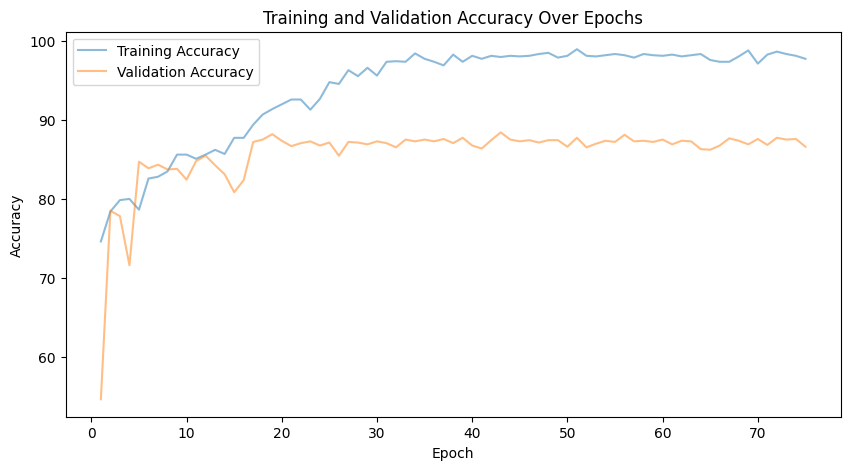

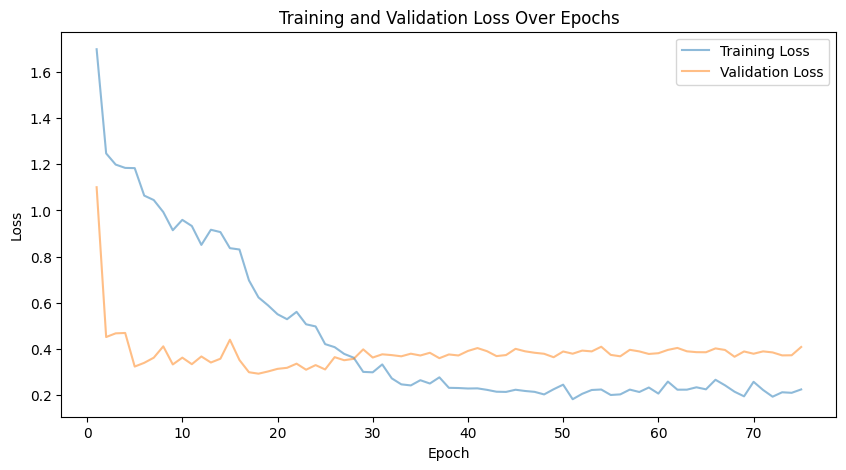

In [40]:
plot_metric('Accuracy', train_acc, val_acc, epochs=num_epochs)
plot_metric('Loss', train_loss, val_loss, epochs=num_epochs)

#### Test

In [41]:
test_loss, test_acc = eval_model(gn_model, criterion, gn_dataset, gn_test_loader, 'test')
print(f'test loss = {test_loss}')
print(f'test acc = {test_acc}')

Validation: 100%|██████████| 21/21 [00:04<00:00,  5.22batch/s, accuracy=86.2, loss=0.41]

test loss = 0.38503676652908325
test acc = 86.21212121212122


## Rest

In [ ]:
# custom_train_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     #transforms.RandomHorizontalFlip(),
#     #transforms.RandomVerticalFlip(),
#     #transforms.RandomRotation(15),
#     #transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     ToTensorAndMove(device),
# ])

# custom_val_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     ToTensorAndMove(device),
# ])

In [ ]:
# google_net_dataset = Data(device, mode='train',
#                                train_transform=custom_train_transform, val_transform=custom_val_transform)

# google_net_dataset.normalize()
# google_net_dataset.train_val_split()

# google_net_train_dataloader = DataLoader(google_net_dataset, batch_size=batch_size, shuffle=True)
# google_net_test_dataloader = DataLoader(google_net_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# google_net_model = GoogLeNet().to(device)
# optimizer = optim.Adam(google_net_model.parameters(), lr=learning_rate)
# train_accuracies, train_losses, val_accuracy, val_losses = train_model(google_net_model, optimizer, criterion,
#                                                                        google_net_train_dataloader, google_net_test_dataloader,
#                                                                        google_net_dataset, num_epochs=num_epochs, device=device)